In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [38]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(3*n/5)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 100

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return -sum(ens).real
    return gamma_beta_objective, history



<ipython-input-39-3a2e1d7ccf7f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


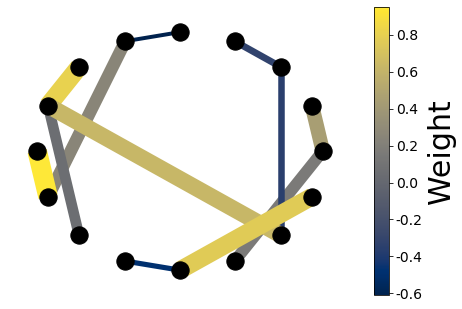

In [39]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [10+10*weights.get(edge, weights.get((edge[1], edge[0]))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [40]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [41]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


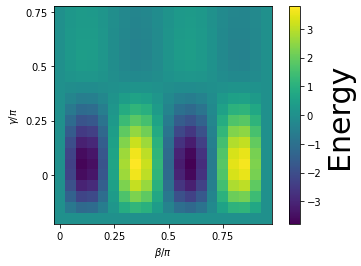

In [42]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [43]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [68]:
from tqdm import tqdm
MAX_ITERATION = 10
shots_per_point = BASELINE_SHOTS
fit_func1, history = expectation_objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [69]:
history, result = test_solver(oes)


 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

(array([ 0.2999397 , -0.40650854]), 2.518690177105538, 2.518690177105538, 0.39269908169872414)


 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

(array([-0.51547246,  0.70752006]), 3.274846531204557, 3.274846531204557, 0.39269908169872414)


 30%|███       | 3/10 [00:02<00:06,  1.09it/s]

(array([ 0.68173966, -0.75298448]), 1.5175811411574731, 1.5175811411574731, 0.39269908169872414)


 40%|████      | 4/10 [00:03<00:05,  1.09it/s]

(array([-0.43525953,  0.41001479]), 2.681197607629499, 2.681197607629499, 0.39269908169872414)


 50%|█████     | 5/10 [00:04<00:04,  1.08it/s]

(array([-0.07173156,  0.44407353]), 0.8172689867500735, 0.8172689867500735, 0.39269908169872414)


 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

(array([ 0.42887266, -0.62471486]), 3.511080606327828, 3.511080606327828, 0.39269908169872414)


 70%|███████   | 7/10 [00:06<00:02,  1.00it/s]

(array([ 0.31671935, -0.54552637]), 3.156167254403787, 3.156167254403787, 0.39269908169872414)


 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

(array([-0.28354692,  0.51464475]), 2.893338010468113, 2.893338010468113, 0.39269908169872414)


 90%|█████████ | 9/10 [00:08<00:01,  1.02s/it]

(array([ 0.47149913, -0.5712727 ]), 3.2273437997494443, 3.2273437997494443, 0.39269908169872414)


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

(array([ 0.37065407, -0.69612013]), 3.6818433279010994, 3.6818433279010994, 0.39269908169872414)
local optimum discovered by solver:
 [ 0.37065407 -0.69612013]
fitness score at this local optimum: 3.6818433279010994


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


([<matplotlib.axis.YTick at 0x7fb4dad914f0>,
 [Text(0, 0.0, '0.75'),
  Text(0, 5.0, '0.5'),
  Text(0, 10.0, '0.25'),
  Text(0, 15.0, '0')])

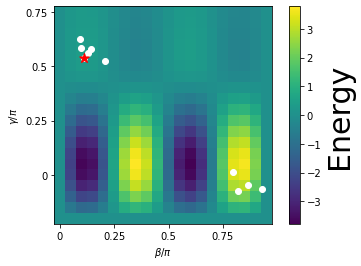

In [70]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])

# Annealing

In [94]:
BASELINE_SHOTS

100

In [ ]:
N

In [71]:
shots_per_point = BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=NPOPULATION,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = result2.fun
(result2.x, result2.fun)        

(array([4.2963322 , 0.74540004]), -3.0544084139822267)

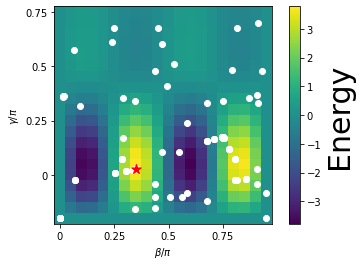

In [72]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
cb.set_label('Energy', fontsize=30)

([<matplotlib.axis.YTick at 0x7fb4d379cd60>,
 [Text(0, 0.025, '0.75'),
  Text(0, 0.07500000000000001, '0.5'),
  Text(0, 0.125, '0.25'),
  Text(0, 0.17500000000000002, '0')])

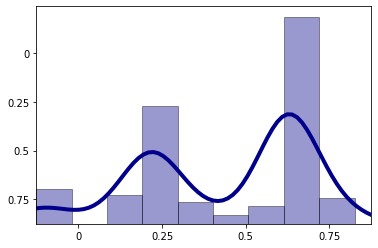

In [93]:
import seaborn as sns
sns.distplot(x2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 20)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])

<AxesSubplot:>

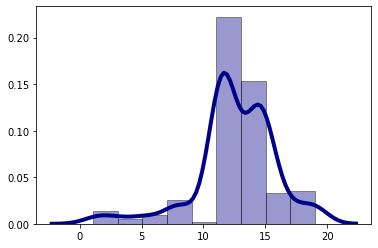

In [86]:
sns.distplot(y2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

(array([16.,  0.,  5., 62.,  7.,  5.,  2., 91., 15.,  9.]),
 array([ 0.        ,  1.89999999,  3.79999999,  5.69999998,  7.59999998,
         9.49999997, 11.39999996, 13.29999996, 15.19999995, 17.09999995,
        18.99999994]),
 <BarContainer object of 10 artists>)

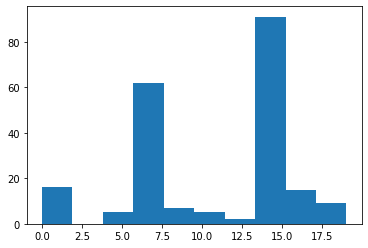

In [76]:
plt.hist(x2)

In [73]:
len(x2)*shots_per_point

21200

In [19]:
weights

{(12, 2): 0.45464230847033815,
 (13, 6): -0.3199301160907462,
 (9, 4): -0.6049936872140034,
 (19, 14): 0.8183591856791752,
 (1, 16): 0.9566939700302572,
 (14, 8): 0.06560508821217659,
 (7, 5): -0.48173630126208833,
 (18, 12): 0.16762523765061044,
 (15, 13): -0.3486186941327827,
 (5, 11): 0.7777986275526183,
 (4, 16): 0.25280905351285,
 (14, 15): 0.6377473811556369}

In [37]:
expectation_objective(graph)[0]((np.array([1.43150866, 1.29356642])))

-1.4231683424570827